In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset("iris")

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [4]:
# 花の種類をsetosa以外の２種類に絞り込む
df2 = df.query('species != "setosa"')

# インデックスを0から振り直す
df2 = df2.reset_index(drop=True)

# petal_widthの項目値をx_dataにセット
X = df2["petal_width"].values

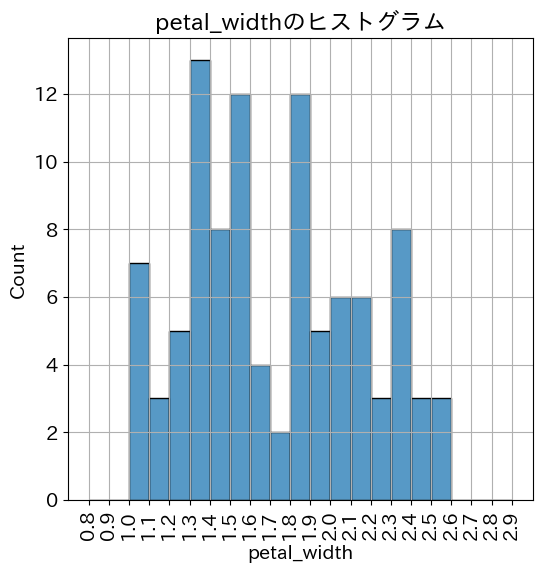

In [5]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(bins=bins, x=X)
ax.set_xlabel("petal_width")
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("petal_widthのヒストグラム")
ax.set_xticks(bins)

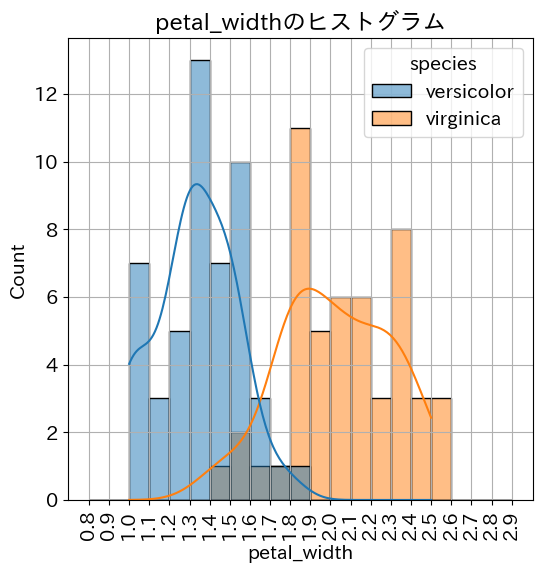

In [6]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x="petal_width", hue="species", kde=True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("petal_widthのヒストグラム")
ax.set_xticks(bins)

In [7]:
# 変数の初期設定

# 何種類の正規分布モデル（混合成分）を仮定するか。
# ここでは「2つの花の種類が混ざって観測されている」という想定で、
# 2成分のガウス混合モデル（Gaussian Mixture Model, GMM）になっている。
n_components = 2

# 観測データ件数（サンプル数）を表すつもりの変数。
# 注意：X.shape は (N,) のような「タプル」を返すので、
# shape を pm 変数の shape に渡すなら通常は X.shape[0] のように
# 整数のサンプル数を使うのが自然である。
# ただし PyMC はタプル shape も許すケースがあるため、ここでは元コードを保持する。
N = X.shape

# PyMC の確率モデルコンテナを作成
model1 = pm.Model()

with model1:
    # X の観測値を Data ノードとしてモデルに埋め込む。
    # これにより「X を固定した条件付きモデル p(X | latent params)」という回帰/生成の立場が明確になり、
    # 後で pm.set_data で差し替えて予測したりもできる。
    X_data = pm.Data("X_data", X)

    # p: 潜在クラス（成分）s_i が 1 をとる確率。
    # 2成分混合の場合、s_i=0 の確率は 1-p で自動的に決まる。
    # 事前は一様分布なので「どちらの成分が多いか分からない」非情報的な仮定。
    p = pm.Uniform("p", lower=0.0, upper=1.0)

    # s: 各観測 i がどちらの成分から来たかを表す潜在ラベル（割当）。
    # s_i ~ Bernoulli(p) により 0/1 を返し、shape=N で全観測分のラベル列を作る。
    # これは「観測ごとの隠れ変数による mixture のスイッチ」を実装している。
    s = pm.Bernoulli("s", p=p, shape=N)

    # mus: 各成分 k の平均 μ_k。
    # 0 を中心に十分広い正規事前を置いており、データから平均位置を学習させる。
    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)

    # taus: 各成分 k の精度（precision）τ_k。
    # 精度は分散の逆数に対応し、τ_k = 1 / σ_k^2 の関係がある。
    # HalfNormal を使うことで τ_k > 0（分散は正）という制約を自然に満たす。
    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)

    # sigmas: 各成分 k の標準偏差 σ_k を、精度 τ_k から決定論的に計算して持っておく。
    # τ_k = 1/σ_k^2 なので σ_k = 1/√τ_k。
    # 理論的には単なる再パラメータ化だが、可視化や解釈には σ の方が直感的なので
    # Deterministic ノードとして保存しておくのが便利。
    sigmas = pm.Deterministic("sigmas", 1 / pm.math.sqrt(taus))

    # mu: 各観測 i に対応する平均 μ_{s_i} を潜在ラベルで切り替えて取得。
    # すなわち
    #   mu_i = mus[0]  if s_i=0
    #   mu_i = mus[1]  if s_i=1
    # という mixture の平均部分を表す決定論的変数。
    mu = pm.Deterministic("mu", mus[s])

    # tau: 各観測 i に対応する精度 τ_{s_i} を潜在ラベルで切り替えて取得。
    # こちらも mixture の分散（精度）部分を観測ごとに選択している。
    tau = pm.Deterministic("tau", taus[s])

    # 観測モデル（尤度）:
    # 各 X_i は、割当 s_i で選ばれた成分の正規分布に従う、という生成過程を表現。
    # つまり
    #   X_i | s_i=k, mus, taus  ~ Normal(mus[k], 1/taus[k])
    # を全 i についてまとめて書いている。
    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X_data)

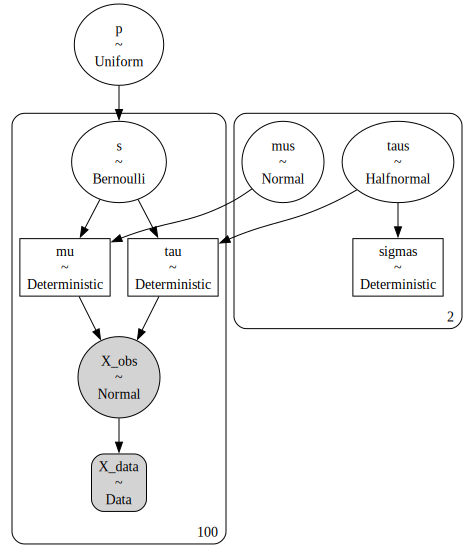

In [8]:
g = pm.model_to_graphviz(model1)
display(g)

In [9]:
with model1:
    idata1 = pm.sample(chains=1, draws=2000, target_accept=0.99, random_seed=42)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Output()

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


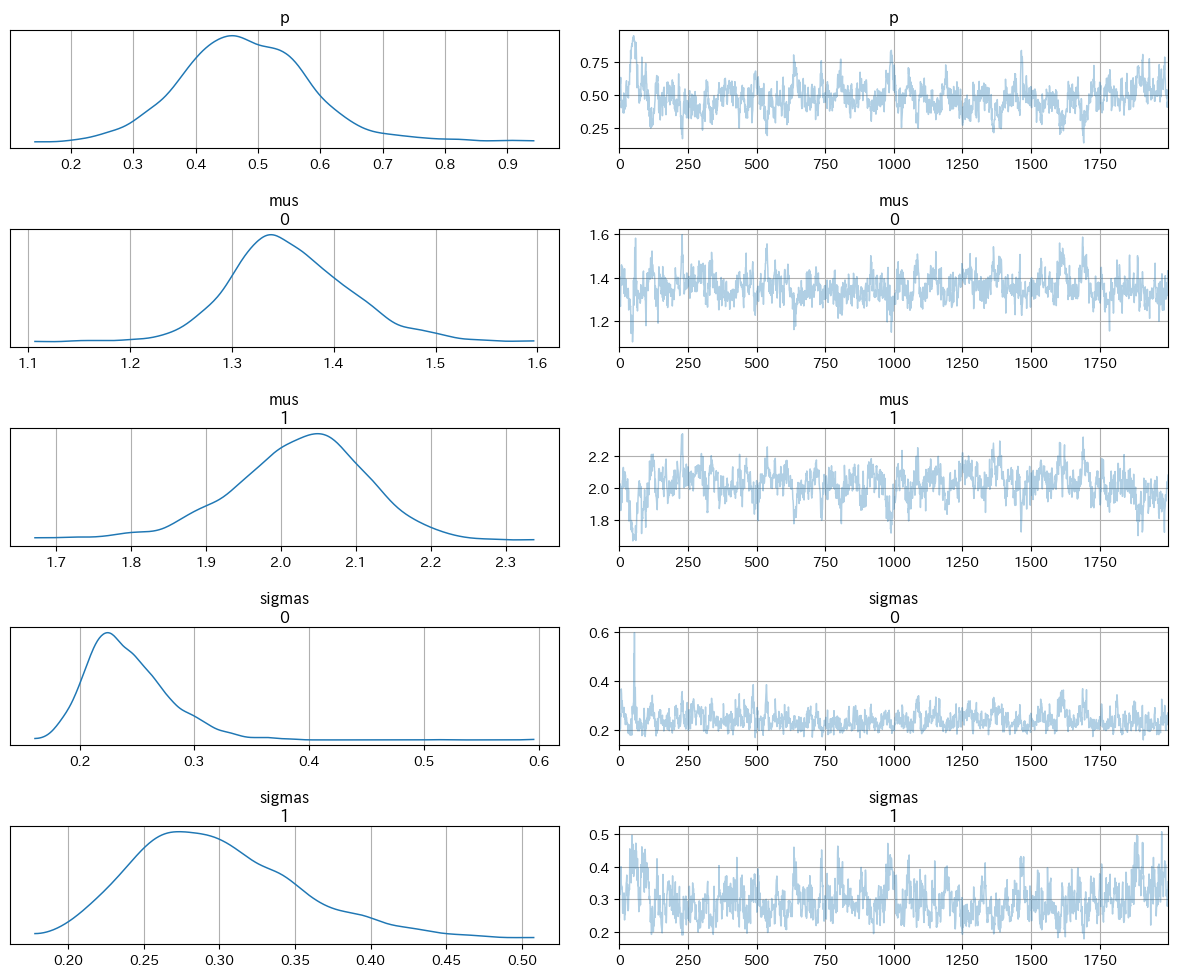

In [10]:
az.plot_trace(idata1, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout()

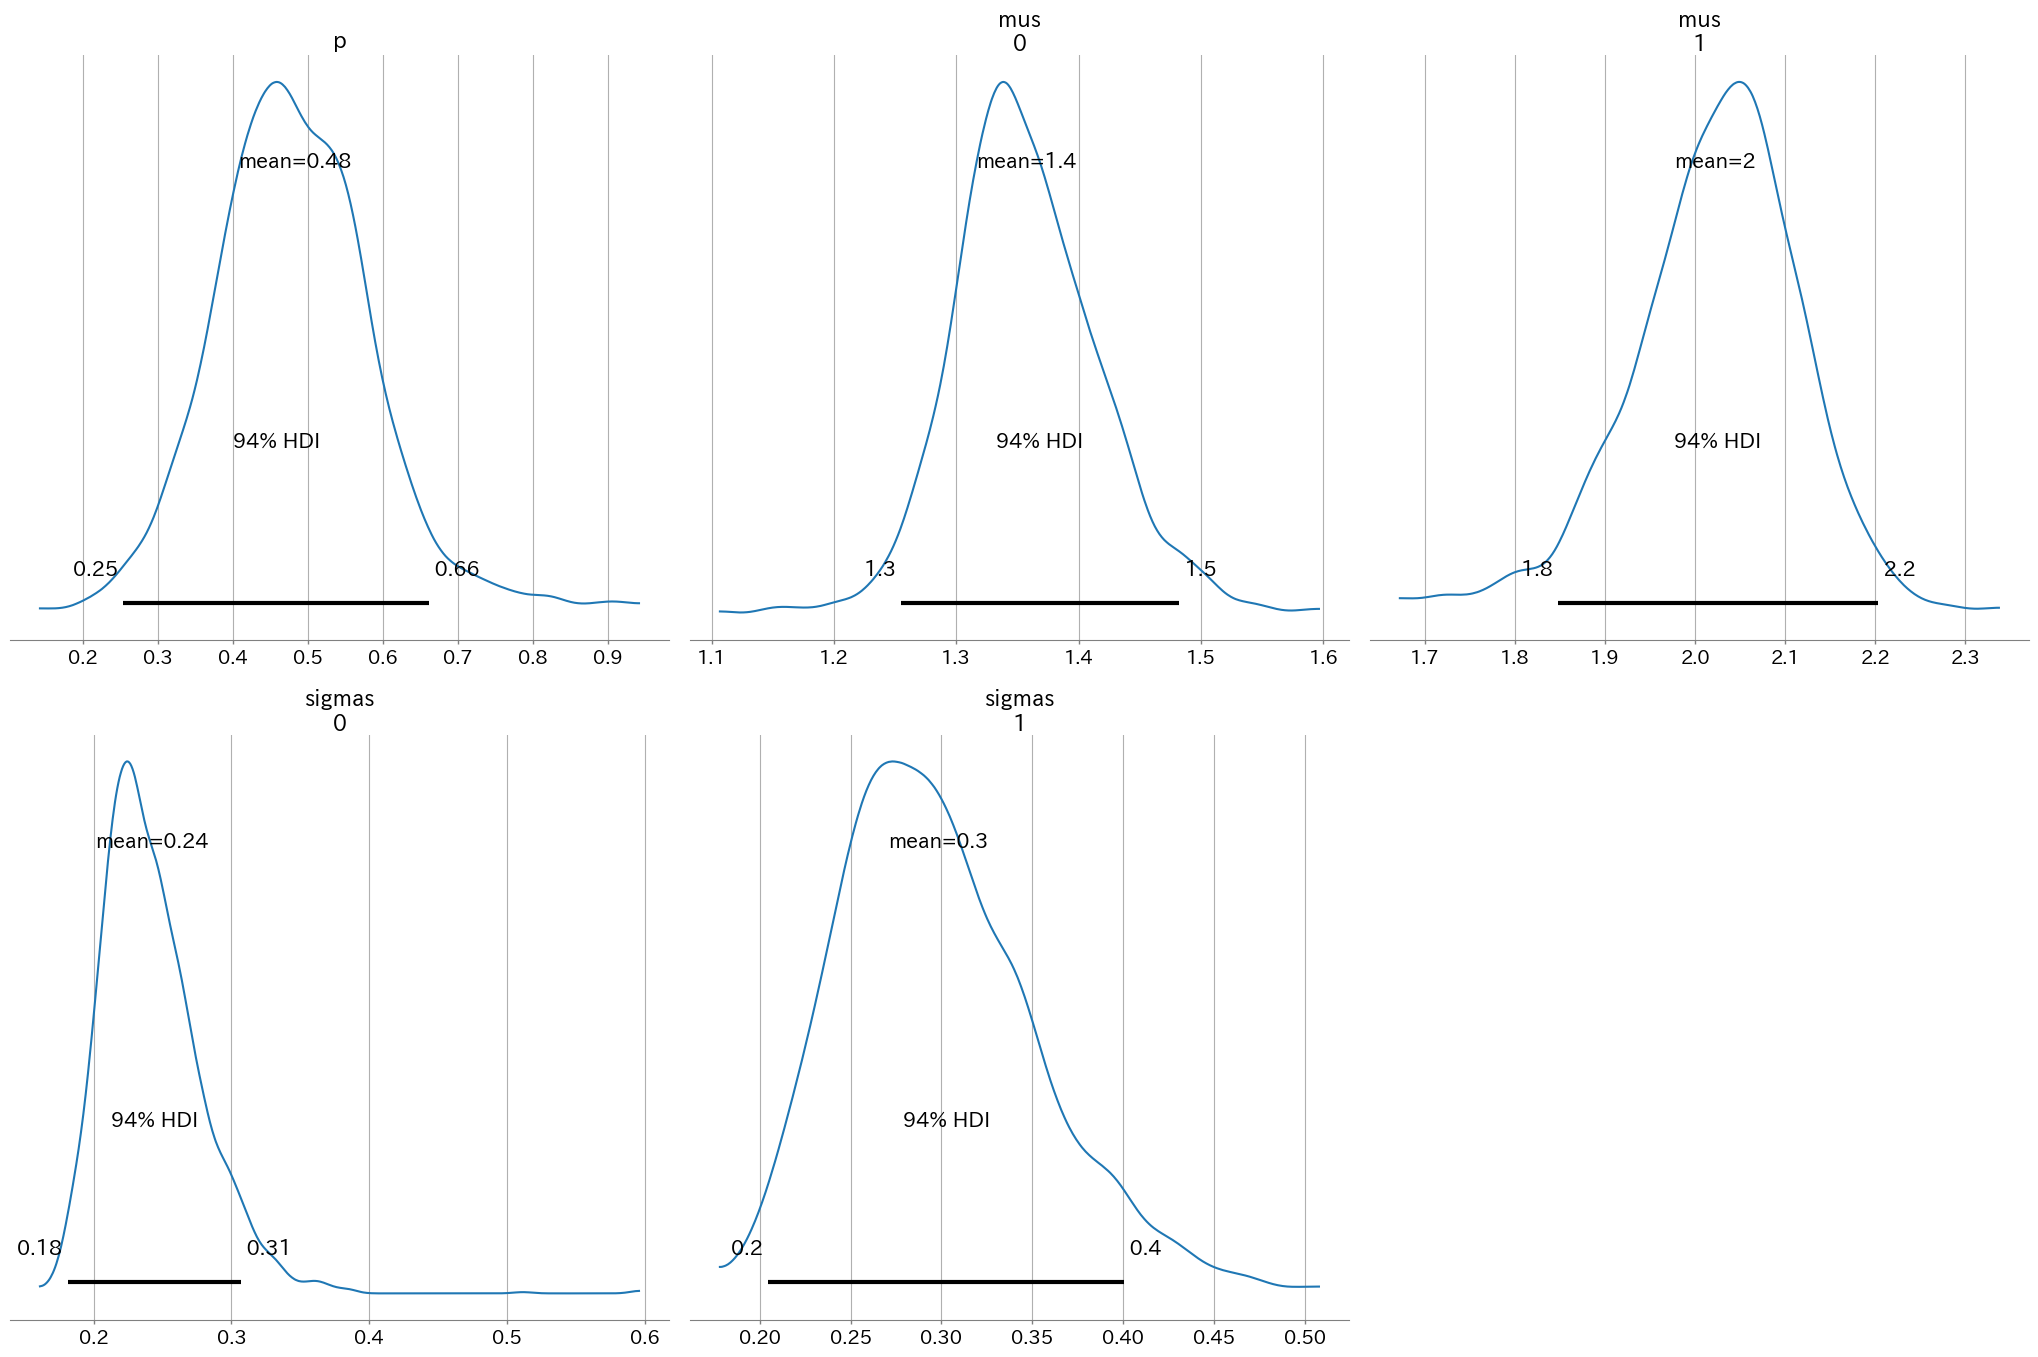

In [11]:
plt.rcParams["figure.figsize"] = (6, 6)
az.plot_posterior(idata1, var_names=["p", "mus", "sigmas"])
plt.tight_layout()

In [12]:
summary1 = az.summary(idata1, var_names=["p", "mus", "sigmas"])
display(summary1)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.483,0.110,0.254,0.662,0.011,0.008,100.000,178.000,NaN
mus[0],1.357,0.060,1.255,1.482,0.005,0.003,176.000,330.000,NaN
mus[1],2.023,0.095,1.848,2.203,0.010,0.006,101.000,131.000,NaN
sigmas[0],0.242,0.036,0.181,0.307,0.002,0.002,274.000,385.000,NaN
sigmas[1],0.298,0.055,0.205,0.400,0.005,0.003,109.000,177.000,NaN


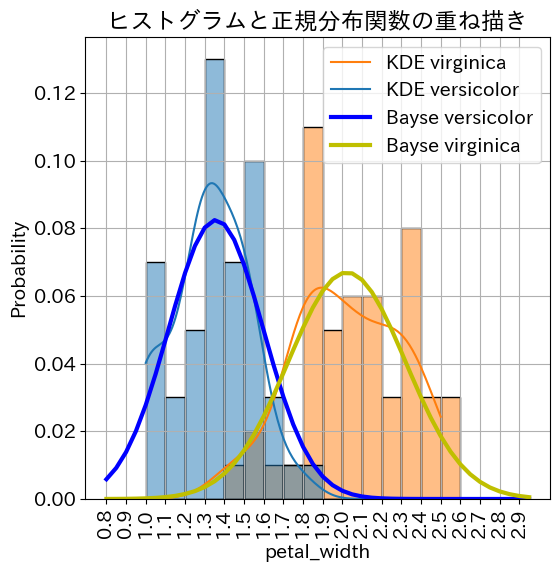

In [13]:
# 正規分布関数の定義
def norm(x, mu, sigma):
    return np.exp(-(((x - mu) / sigma) ** 2) / 2) / (np.sqrt(2 * np.pi) * sigma)


# 推論結果から各パラメータの平均値を取得
mean = summary1["mean"]

# muの平均値取得
mean_mu0 = mean["mus[0]"]
mean_mu1 = mean["mus[1]"]

# sigmaの平均値取得
mean_sigma0 = mean["sigmas[0]"]
mean_sigma1 = mean["sigmas[1]"]

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

# グラフ描画
bins = np.arange(0.8, 3.0, delta)
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sns.histplot(
    data=df2,
    bins=bins,
    x="petal_width",
    hue="species",
    kde=True,
    ax=ax,
    stat="probability",
)
ax.get_lines()[1].set_label("KDE versicolor")
ax.get_lines()[0].set_label("KDE virginica")
ax.plot(x, y0, c="b", lw=3, label="Bayse versicolor")
ax.plot(x, y1, c="y", lw=3, label="Bayse virginica")
ax.set_xticks(bins)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("ヒストグラムと正規分布関数の重ね描き")
plt.legend()

In [14]:
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]

df_heads = pd.DataFrame(None)

# petal_widthの値が1.0から2.5までそれぞれの値である先頭の行を抽出
for value in value_list:

    # df2からpetal_widthの値がvalueである行のみ抽出
    w = df2.query("petal_width == @value", engine="python")

    # 先頭の１行を抽出し、df_headsに連結
    df_heads = pd.concat([df_heads, w.head(1)], axis=0)

# 結果確認
display(df_heads)

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.900,2.400,3.300,1.000,versicolor
1,6.400,3.200,4.500,1.500,versicolor
27,6.700,3.000,5.000,1.700,versicolor
60,6.500,3.200,5.100,2.000,virginica
50,6.300,3.300,6.000,2.500,virginica


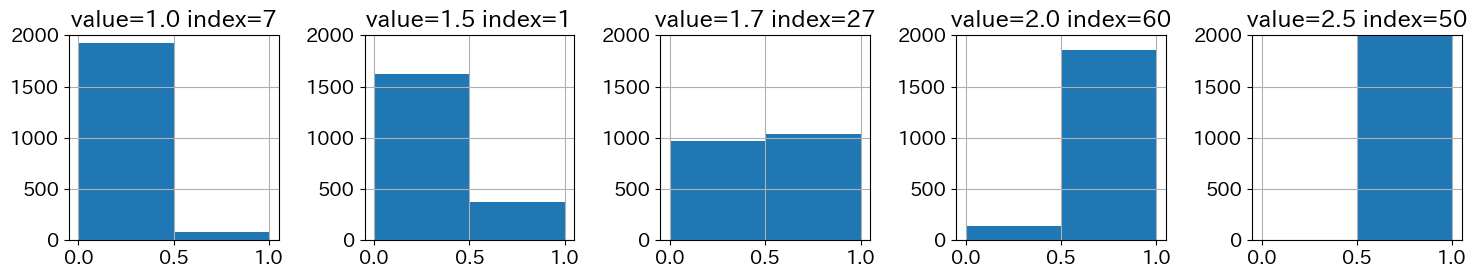

In [15]:
# df_headsのインデックスを抽出
indexes, n_indexes = df_heads.index, len(df_heads)

# 潜在変数sのサンプル値から、index=7, 1, 27, 60, 50の値を抽出
sval = idata1.posterior["s"][:, :, indexes].values.reshape(-1, n_indexes).T

# それぞれのケースでヒストグラムの描画
plt.rcParams["figure.figsize"] = (15, 3)
vlist = df_heads["petal_width"]
fig, axes = plt.subplots(1, n_indexes)
for ax, item, value, index in zip(axes, sval, vlist, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0, 2000)
    ax.set_title(f"value={value} index={index}")
plt.tight_layout()

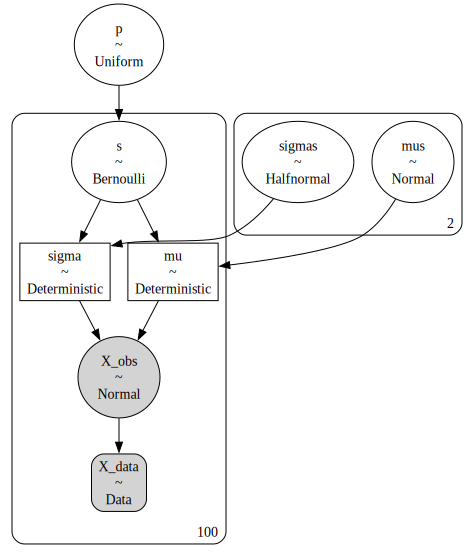

In [16]:
model2 = pm.Model()

with model2:
    # X の観測値を pm.Data としてモデルに埋め込む。
    # pm.Data を使うと、推論後に pm.set_data で X を差し替えて
    # 予測分布 p(X_new | posterior) を計算する、といったベイズ推論の標準的ワークフローに拡張しやすい。
    X_data = pm.Data("X_data", X)

    # p: 「潜在クラス s_i が 1 になる確率（混合比）」。
    # 2 成分混合モデルにおける mixing proportion に対応する。
    # 一様分布 Uniform(0,1) は p に対して非情報的（どの混合比も同程度にあり得る）事前。
    p = pm.Uniform("p", lower=0.0, upper=1.0)

    # s: 各観測 i がどちらの成分（0 or 1）に属するかを表す潜在割当変数。
    # s_i | p ~ Bernoulli(p) という階層で、p が「全体のクラス割合」を決め、
    # s が「個々の観測の所属」を決める、という混合モデルの典型構造になっている。
    # shape=N は「観測数 n と同じ長さの潜在変数列」を作る意図。
    # ※ N は X.shape だとタプルになり得るため、意図が曖昧なら len(X) にする方が安全だが、
    #    ここでは元コードのまま潜在変数の次元として使っている。
    s = pm.Bernoulli("s", p=p, shape=N)

    # mus: 2 つの正規分布成分それぞれの平均ベクトル（μ_0, μ_1）。
    # mus_k ~ Normal(0, 10^2) は「平均は 0 近傍から大きく外れてもよい」という広い事前で、
    # 成分平均の位置は主にデータにより決まるようにしている。
    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)

    # sigmas: 2 つの正規分布成分それぞれの標準偏差ベクトル（σ_0, σ_1）。
    # HalfNormal は σ_k >= 0 を自然に保証する尺度パラメータ用の事前。
    # sigma=10 はかなり広いので「分散情報をほぼデータに委ねる」設定になっている。
    sigmas = pm.HalfNormal("sigmas", sigma=10.0, shape=n_components)

    # 各観測 i に対し、潜在割当 s_i に応じて平均と標準偏差を切り替える。
    # 具体的には mu_i = mus_{s_i}, sigma_i = sigmas_{s_i}。
    # pm.Deterministic にすることで、事後サンプルごとの mu, sigma を保存し、
    # 「各点がどの成分に引き寄せられているか」「成分ごとの分離がどれだけ明確か」を後で可視化できる。
    mu = pm.Deterministic("mu", mus[s])
    sigma = pm.Deterministic("sigma", sigmas[s])

    # 観測 X_i の生成モデル（尤度）。
    # X_i | s_i=k, mus, sigmas ~ Normal(mus_k, sigmas_k^2) という混合尤度を、
    # 潜在変数 s を介して「成分別正規分布の切り替え」として実装している。
    # observed=X_data により、ここが「データが与える情報（尤度項）」になる。
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X_data)

# 確率モデルの構造を Graphviz で可視化する。
# p → s → (mu, sigma) → X_obs という混合モデルの依存関係を図として確認でき、
# 教材として「生成過程とコードの対応」を点検するのに有効。
g = pm.model_to_graphviz(model2)
display(g)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, sigmas]
>BinaryGibbsMetropolis: [s]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


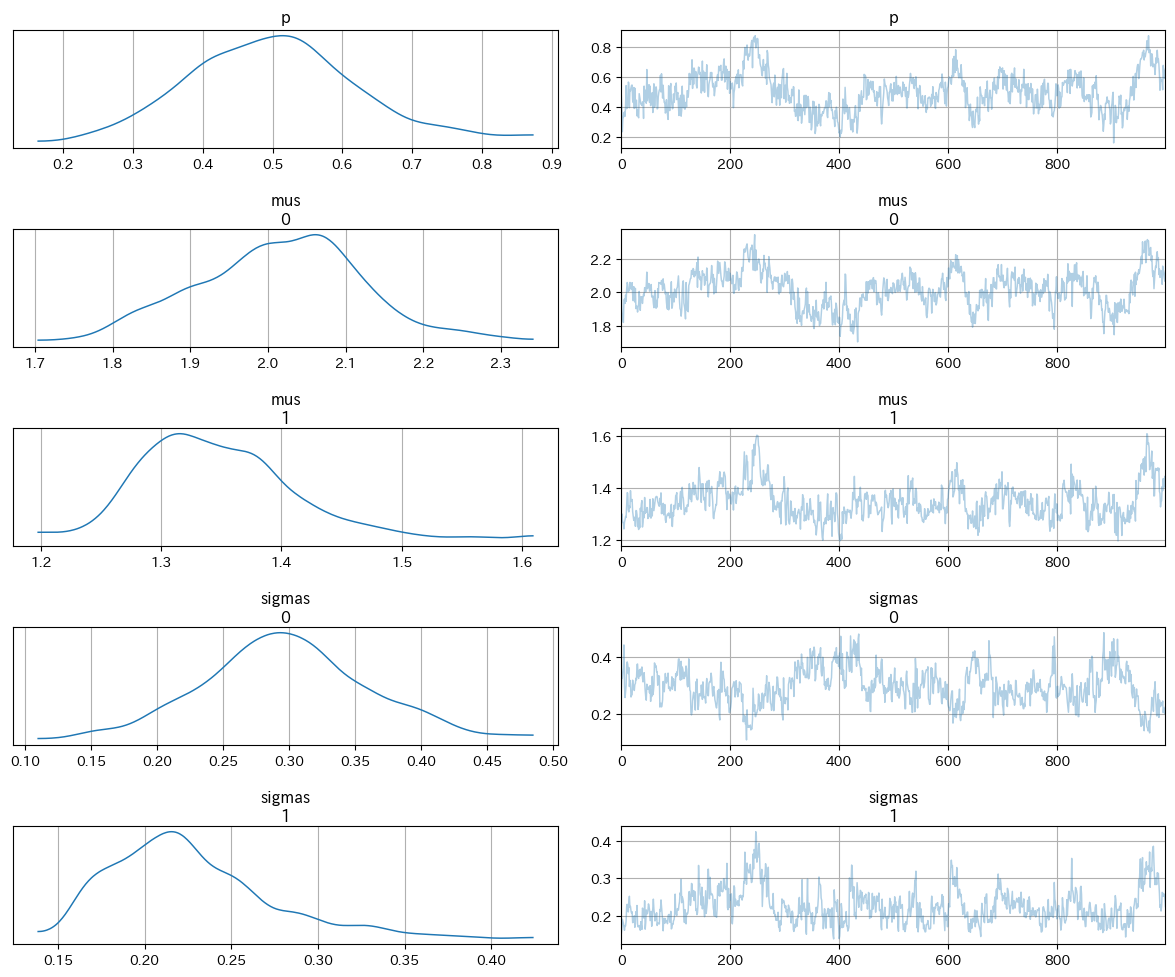

In [17]:
with model2:
    # サンプリング
    idata2 = pm.sample(random_seed=42, chains=1, target_accept=0.998)

# plot_trace関数で推論結果の確認
az.plot_trace(idata2, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout()

In [18]:
summary2 = az.summary(idata2, var_names=["p", "mus", "sigmas"])
display(summary2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.503,0.122,0.287,0.758,0.024,0.013,25.000,48.000,NaN
mus[0],2.015,0.106,1.791,2.188,0.021,0.010,26.000,55.000,NaN
mus[1],1.348,0.067,1.233,1.478,0.011,0.008,37.000,54.000,NaN
sigmas[0],0.297,0.062,0.188,0.421,0.011,0.004,34.000,83.000,NaN
sigmas[1],0.226,0.046,0.155,0.319,0.007,0.005,45.000,80.000,NaN
